In [1]:
import base64
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns
import shutil
import torch
from torch import distributions, nn
import torch.nn.functional as F
import time
import tqdm

# Custom imports
from graph_nns import GraphNN_A3C
import vectorized_env
from vectorized_env import KaggleMABEnvTorchVectorized
import vectorized_agents as va

%matplotlib inline
jtplot.style()

DEVICE = torch.device('cuda')
OBS_NORM = 100. / 1999.

## A3C RL algorithm

In [2]:
def wrap_model(model):
    def model_wrapped(states):
        return model.sample_action(states.unsqueeze(0)).squeeze(0)
    return model_wrapped


class A3CVectorized():
    def __init__(self, model_constructor, optimizer, model=None, device=torch.device('cuda'), exp_folder=Path('/home/isaiah/GitHub/Kaggle/Santa_2020/runs/TEMP'),
                 play_against_past_selves=True, n_past_selves=8, checkpoint_freq=10, initial_opponent_pool=[], opp_posterior_decay=0.95):
        self.model_constructor = model_constructor
        self.optimizer = optimizer
        if model is None:
            self.model = self.model_constructor()
        else:
            self.model = model
        self.device = device
        self.exp_folder = exp_folder
        if self.exp_folder.name == 'TEMP':
            print('WARNING: Using TEMP exp_folder')
            shutil.rmtree(self.exp_folder)
        elif self.exp_folder.exists():
            raise RuntimeError(f'Experiment folder {self.exp_folder} already exists')
        else:
            print(f'Saving results to {self.exp_folder}')
        self.exp_folder.mkdir(exist_ok=True)
        self.play_against_past_selves = play_against_past_selves
        self.n_past_selves = n_past_selves
        self.checkpoint_freq = checkpoint_freq
        self.initial_opponent_pool = initial_opponent_pool
        self.opp_posterior_decay = opp_posterior_decay
        
        self.env = None
        self.opp_a = np.ones(len(self.initial_opponent_pool))
        self.opp_b = np.ones(len(self.initial_opponent_pool))
        self.checkpoints = []
        self.true_ep_num = 0
        
    def train(self, n_episodes, batch_size=30, gamma=0.9, **env_kwargs):
        if self.play_against_past_selves and 'opponent' in env_kwargs.keys():
            raise RuntimeError('Cannot play against past selves when opponent is defined')
        self.env = None
        self.model.train()
        episode_reward_sums = []
        
        for ep_num in tqdm.trange(n_episodes):
            if self.play_against_past_selves:
                opponents, opponent_idxs = self.sample_opponents()
                self.env = KaggleMABEnvTorchVectorized(opponent=opponents, **env_kwargs)
            else:
                self.env = KaggleMABEnvTorchVectorized(**env_kwargs)
            buffer_s, buffer_a, buffer_r = [], [], []
            s, r, _, _ = self.env.reset()
            episode_reward_sums.append(r)
            step_count = 1
            while not self.env.done:
                # Batch size of 1 for inference
                a = self.model.sample_action(s.to(device=self.device).unsqueeze(0)).squeeze(0)
                next_s, r, done, _ = self.env.step(a)

                buffer_s.append(s)
                buffer_a.append(a)
                buffer_r.append(r)

                if step_count % batch_size == 0 or done:
                    if done:
                        v_next_s = torch.zeros_like(buffer_r[-1])
                    else:
                        _, v_next_s = self.model(next_s.to(device=self.device).unsqueeze(0))
                        v_next_s = v_next_s.detach().squeeze(0)
                    v_next_s.to(device=self.device)

                    buffer_v_target = []
                    for r in buffer_r[::-1]:
                        v_next_s = r + gamma * v_next_s
                        buffer_v_target.append(v_next_s)
                    buffer_v_target.reverse()

                    loss = self.model.loss_func(
                        torch.stack(buffer_s).to(device=self.device),
                        torch.stack(buffer_a).to(device=self.device),
                        torch.stack(buffer_v_target).to(device=self.device)
                    )
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    buffer_s, buffer_a, buffer_r = [], [], []
                s = next_s
                episode_reward_sums[-1] += r
                step_count += 1
            if self.play_against_past_selves:
                if opponent_idxs is not None:
                    self.update_opponent_scores(opponent_idxs, self.env.player_rewards_sums.cpu())
                if ep_num % self.checkpoint_freq == 0:
                    self.checkpoint()
            if ep_num % self.checkpoint_freq == 0:
                self.save()
            episode_reward_sums[-1] = episode_reward_sums[-1].mean() / self.env.r_norm
            self.true_ep_num += 1
        self.save(finished=True)
        return episode_reward_sums
    
    def sample_opponents(self):
        if len(self.initial_opponent_pool) + len(self.checkpoints) == 0:
            print('No opponents sampled')
            return None, None
        else:
            opponents = []
            opponent_idxs = []
            for i in range(self.n_past_selves):
                # Sample opponents randomly if the agent is losing > 2/3 of it's games, otherwise use thompson sampling
                if self.env is None or np.sum(self.opp_b - 1) <= self.env.n_envs / 3.:
                    selected_opp_idx = np.random.randint(len(self.opp_a))
                else:
                    selected_opp_idx = np.random.beta(self.opp_a, self.opp_b).argmax()
                opponent_idxs.append(selected_opp_idx)
                opponents.append(self.get_opponent(selected_opp_idx))
                if selected_opp_idx < len(self.initial_opponent_pool):
                    try:
                        print(f'Opponent {i}: {opponents[-1].name} with alpha {self.opp_a[selected_opp_idx]:.2f} and beta {self.opp_b[selected_opp_idx]:.2f}')
                    except AttributeError:
                        print(f'Opponent {i}: {opponents[-1]} with alpha {self.opp_a[selected_opp_idx]:.2f} and beta {self.opp_b[selected_opp_idx]:.2f}')
                else:
                    print(f'Opponent {i}: Checkpoint #{selected_opp_idx - len(self.initial_opponent_pool)} with alpha {self.opp_a[selected_opp_idx]:.2f} and beta {self.opp_b[selected_opp_idx]:.2f}')
            print()
            return va.MultiAgent(opponents), opponent_idxs

    def update_opponent_scores(self, curr_opp_idxs, player_rewards_sums):
        # player_rewards_sums.shape is (n_envs, n_players, n_bandits)
        # Decay posteriors
        self.opp_a = np.maximum(self.opp_a * self.opp_posterior_decay, 1.)
        self.opp_b = np.maximum(self.opp_b * self.opp_posterior_decay, 1.)
        
        # Update posteriors with new w/l stats
        global game_scores, rewards_sums
        rewards_sums = player_rewards_sums.sum(dim=2)
        game_scores = torch.zeros(rewards_sums.shape)
        winners_idxs = rewards_sums.argmax(dim=1)
        draws_mask = rewards_sums[:,0] == rewards_sums[:,1]
        game_scores[torch.arange(game_scores.shape[0]), winners_idxs] = 1.
        game_scores[draws_mask] = 0.5
        game_scores = [gs.numpy() for gs in game_scores.chunk(self.n_past_selves)]
        for match_idx, opp_idx in enumerate(curr_opp_idxs):
            self.opp_a[opp_idx] += game_scores[match_idx][:,1].sum()
            self.opp_b[opp_idx] += game_scores[match_idx][:,0].sum()
            
    def checkpoint(self):
        self.model.cpu()
        self.checkpoints.append(self.model.state_dict())
        self.opp_a = np.append(self.opp_a, 1.)
        self.opp_b = np.append(self.opp_b, 1.)
        self.model.to(device=self.device)
    
    def save(self, finished=False):
        if finished:
            file_path_base = self.exp_folder / 'final'
        else:
            file_path_base = self.exp_folder / str(self.true_ep_num)
        # Save model params
        self.model.cpu()
        state_dict_bytes = pickle.dumps({
            'model_state_dict': self.model.state_dict(),
        })
        serialized_string = base64.b64encode(state_dict_bytes)
        with open(f'{file_path_base}_cp.txt', 'w') as f:
            f.write(str(serialized_string))
        self.model.to(device=self.device)
        # Save skill estimates
        if self.play_against_past_selves:
            checkpoint_idxs = np.arange(len(a3c_alg.opp_a)) - len(a3c_alg.initial_opponent_pool)
            checkpoint_idxs = np.where(
                checkpoint_idxs < 0,
                np.nan,
                checkpoint_idxs
            )
            df = pd.DataFrame({
                'opp_a': a3c_alg.opp_a,
                'opp_b': a3c_alg.opp_b,
                'est_opp_skill': a3c_alg.opp_a / (a3c_alg.opp_a + a3c_alg.opp_b),
                'checkpoint_idxs': checkpoint_idxs
            })
            df.to_csv(f'{file_path_base}_skill_estimates.csv')
    
    def get_opponent(self, idx):
        if idx < 0:
            raise IndexError(f'Negative indexing is not supported')
        elif idx < len(self.initial_opponent_pool):
            return self.initial_opponent_pool[idx]
        elif idx < len(self.initial_opponent_pool) + len(self.checkpoints):
            checkpoint_idx = idx - len(self.initial_opponent_pool)
            checkpoint_opp = self.model_constructor()
            checkpoint_opp.load_state_dict(self.checkpoints[checkpoint_idx])
            checkpoint_opp.to(device=self.device)
            checkpoint_opp.eval()
            return checkpoint_opp
        else:
            raise IndexError(f'Index {idx} is out of bounds')

## Optional: load a saved model state_dict from a serialized string file

In [7]:
#with open('rl_agents/ss_temp.txt', 'r') as f:
with open('rl_agents/ss_a3c_agent_v3.txt', 'r') as f:
    serialized_string = f.readline()[2:-1].encode()
state_dict_bytes = base64.b64decode(serialized_string)
loaded_state_dicts = pickle.loads(state_dict_bytes)

## RL training
#### TODO:
Implement "fictitious self-play" to improve trained model robustness. On a related note, maybe compare trained agents against many/all agents from this notebook: https://www.kaggle.com/jamesmcguigan/santa-2020-agents-comparison

Implement new RL algorithm - AWAC, and use top team's logs as training data. See: https://www.kaggle.com/masatomatsui/santa-episode-scraper

Eventually, experiment with reward_type = END_OF_GAME

In [5]:
graph_nn_kwargs = dict(
    in_features=3,
    n_nodes=100,
    n_hidden_layers=1,
    layer_sizes=16,
    skip_connection_n=1
)
model = GraphNN_A3C(**graph_nn_kwargs)
try:
    sd = loaded_state_dicts['model_state_dict']
    model.load_state_dict(sd)
    print('Successfully loaded saved model')
    del loaded_state_dicts
except NameError:
    pass
model.to(device=DEVICE)
optimizer = torch.optim.Adam(model.parameters())

env_kwargs = dict(
    n_envs=512,
    out_device=DEVICE,
    reward_type=vectorized_env.EVERY_STEP_EV
)
rl_alg_kwargs = dict(
    batch_size=30,
    gamma=0.99
)

# Used for va.run_vectorized_vs
def model_wrapped(states):
    return model.sample_action(states.unsqueeze(0)).squeeze(0)

def model_constructor():
    return GraphNN_A3C(**graph_nn_kwargs)

# initial_opponent_pool = []
initial_opponent_pool = [
    va.BasicThompsonSampling(OBS_NORM),
    va.PullVegasSlotMachines(OBS_NORM),
    va.SavedRLAgent('a3c_agent_v0'),
    va.SavedRLAgent('a3c_agent_v1'),
    va.SavedRLAgent('a3c_agent_v2'),
    #va.SavedRLAgent('a3c_agent_v3'),
]

a3c_alg = A3CVectorized(model_constructor, optimizer, model=model, device=DEVICE,
                        play_against_past_selves=True,
                        n_past_selves=8,
                        checkpoint_freq=1,
                        initial_opponent_pool=initial_opponent_pool,
                        opp_posterior_decay=0.95)

  0%|          | 0/3 [00:00<?, ?it/s]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 1.00 and beta 1.00
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 1.00 and beta 1.00
Opponent 2: SavedRLAgent: a3c_agent_v0 with alpha 1.00 and beta 1.00
Opponent 3: SavedRLAgent: a3c_agent_v1 with alpha 1.00 and beta 1.00
Opponent 4: PullVegasSlotMachines with alpha 1.00 and beta 1.00
Opponent 5: PullVegasSlotMachines with alpha 1.00 and beta 1.00
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 1.00 and beta 1.00
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 1.00 and beta 1.00



 33%|███▎      | 1/3 [00:09<00:18,  9.06s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 257.00 and beta 1.00
Opponent 1: PullVegasSlotMachines with alpha 129.00 and beta 1.00
Opponent 2: Checkpoint #0 with alpha 1.00 and beta 1.00
Opponent 3: SavedRLAgent: a3c_agent_v0 with alpha 65.00 and beta 1.00
Opponent 4: SavedRLAgent: a3c_agent_v0 with alpha 65.00 and beta 1.00
Opponent 5: Checkpoint #0 with alpha 1.00 and beta 1.00
Opponent 6: SavedRLAgent: a3c_agent_v0 with alpha 65.00 and beta 1.00
Opponent 7: Checkpoint #0 with alpha 1.00 and beta 1.00



 67%|██████▋   | 2/3 [00:18<00:09,  9.03s/it]

Opponent 0: BasicThompsonSampling with alpha 1.00 and beta 1.00
Opponent 1: SavedRLAgent: a3c_agent_v1 with alpha 61.75 and beta 1.00
Opponent 2: PullVegasSlotMachines with alpha 186.55 and beta 1.00
Opponent 3: PullVegasSlotMachines with alpha 186.55 and beta 1.00
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 308.15 and beta 1.00
Opponent 5: SavedRLAgent: a3c_agent_v1 with alpha 61.75 and beta 1.00
Opponent 6: BasicThompsonSampling with alpha 1.00 and beta 1.00
Opponent 7: Checkpoint #0 with alpha 192.00 and beta 2.00



100%|██████████| 3/3 [00:24<00:00,  8.09s/it]


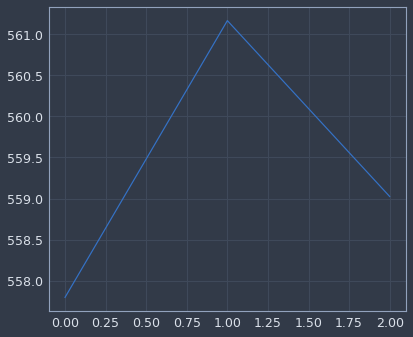

In [6]:
env_kwargs['n_envs'] = 512
episode_reward_sums = a3c_alg.train(n_episodes=3, **rl_alg_kwargs, **env_kwargs)

#episode_reward_sums = a3c_vectorized_env(env, model, optimizer, n_episodes=50, **rl_alg_kwargs)
plt.plot(episode_reward_sums)
plt.show();
#plt.plot(episode_reward_sums);

  0%|          | 0/30 [00:00<?, ?it/s]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 7224.75 and beta 3474.96
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 7224.75 and beta 3474.96
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 7224.75 and beta 3474.96
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 7224.75 and beta 3474.96
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 7224.75 and beta 3474.96
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 7224.75 and beta 3474.96
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 7224.75 and beta 3474.96
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 7224.75 and beta 3474.96



  3%|▎         | 1/30 [00:15<07:30, 15.55s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 7518.51 and beta 3446.21
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 7518.51 and beta 3446.21
Opponent 2: Checkpoint #5 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #5 with alpha 1.00 and beta 1.00
Opponent 4: Checkpoint #5 with alpha 1.00 and beta 1.00
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 7518.51 and beta 3446.21
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 7518.51 and beta 3446.21
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 7518.51 and beta 3446.21



  7%|▋         | 2/30 [00:31<07:17, 15.61s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 7497.58 and beta 3418.90
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 7497.58 and beta 3418.90
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 7497.58 and beta 3418.90
Opponent 3: Checkpoint #5 with alpha 207.00 and beta 95.00
Opponent 4: Checkpoint #5 with alpha 207.00 and beta 95.00
Opponent 5: Checkpoint #5 with alpha 207.00 and beta 95.00
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 7497.58 and beta 3418.90
Opponent 7: Checkpoint #5 with alpha 207.00 and beta 95.00



 10%|█         | 3/30 [00:46<07:00, 15.57s/it]

Opponent 0: Checkpoint #5 with alpha 499.65 and beta 187.25
Opponent 1: Checkpoint #5 with alpha 499.65 and beta 187.25
Opponent 2: Checkpoint #5 with alpha 499.65 and beta 187.25
Opponent 3: Checkpoint #5 with alpha 499.65 and beta 187.25
Opponent 4: Checkpoint #5 with alpha 499.65 and beta 187.25
Opponent 5: Checkpoint #5 with alpha 499.65 and beta 187.25
Opponent 6: Checkpoint #5 with alpha 499.65 and beta 187.25
Opponent 7: Checkpoint #5 with alpha 499.65 and beta 187.25



 13%|█▎        | 4/30 [01:00<06:30, 15.01s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 7047.29 and beta 3184.83
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 7047.29 and beta 3184.83
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 7047.29 and beta 3184.83
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 7047.29 and beta 3184.83
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 7047.29 and beta 3184.83
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 7047.29 and beta 3184.83
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 7047.29 and beta 3184.83
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 7047.29 and beta 3184.83



 17%|█▋        | 5/30 [01:16<06:21, 15.26s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 7169.93 and beta 3350.59
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 7169.93 and beta 3350.59
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 7169.93 and beta 3350.59
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 7169.93 and beta 3350.59
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 7169.93 and beta 3350.59
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 7169.93 and beta 3350.59
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 7169.93 and beta 3350.59
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 7169.93 and beta 3350.59



 20%|██        | 6/30 [01:32<06:11, 15.50s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 7390.93 and beta 3403.56
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 7390.93 and beta 3403.56
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 7390.93 and beta 3403.56
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 7390.93 and beta 3403.56
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 7390.93 and beta 3403.56
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 7390.93 and beta 3403.56
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 7390.93 and beta 3403.56
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 7390.93 and beta 3403.56



 23%|██▎       | 7/30 [01:48<06:03, 15.82s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 7625.39 and beta 3429.38
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 7625.39 and beta 3429.38
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 7625.39 and beta 3429.38
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 7625.39 and beta 3429.38
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 7625.39 and beta 3429.38
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 7625.39 and beta 3429.38
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 7625.39 and beta 3429.38
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 7625.39 and beta 3429.38



 27%|██▋       | 8/30 [02:04<05:48, 15.85s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 7894.12 and beta 3407.91
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 7894.12 and beta 3407.91
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 7894.12 and beta 3407.91
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 7894.12 and beta 3407.91
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 7894.12 and beta 3407.91
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 7894.12 and beta 3407.91
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 7894.12 and beta 3407.91
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 7894.12 and beta 3407.91



 30%|███       | 9/30 [02:20<05:33, 15.88s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8110.41 and beta 3426.52
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8110.41 and beta 3426.52
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8110.41 and beta 3426.52
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8110.41 and beta 3426.52
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 8110.41 and beta 3426.52
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8110.41 and beta 3426.52
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 8110.41 and beta 3426.52
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 8110.41 and beta 3426.52



 33%|███▎      | 10/30 [02:36<05:18, 15.90s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8304.39 and beta 3455.69
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8304.39 and beta 3455.69
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8304.39 and beta 3455.69
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8304.39 and beta 3455.69
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 8304.39 and beta 3455.69
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8304.39 and beta 3455.69
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 8304.39 and beta 3455.69
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 8304.39 and beta 3455.69



 37%|███▋      | 11/30 [02:52<05:02, 15.93s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8471.67 and beta 3500.41
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8471.67 and beta 3500.41
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8471.67 and beta 3500.41
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8471.67 and beta 3500.41
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 8471.67 and beta 3500.41
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8471.67 and beta 3500.41
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 8471.67 and beta 3500.41
Opponent 7: Checkpoint #6 with alpha 1.00 and beta 1.00



 40%|████      | 12/30 [03:08<04:46, 15.90s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8488.09 and beta 3585.39
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8488.09 and beta 3585.39
Opponent 2: Checkpoint #6 with alpha 65.50 and beta 36.50
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8488.09 and beta 3585.39
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 8488.09 and beta 3585.39
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8488.09 and beta 3585.39
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 8488.09 and beta 3585.39
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 8488.09 and beta 3585.39



 43%|████▎     | 13/30 [03:24<04:29, 15.88s/it]

Opponent 0: Checkpoint #6 with alpha 135.22 and beta 61.67
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8589.68 and beta 3580.12
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8589.68 and beta 3580.12
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8589.68 and beta 3580.12
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 8589.68 and beta 3580.12
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8589.68 and beta 3580.12
Opponent 6: Checkpoint #6 with alpha 135.22 and beta 61.67
Opponent 7: Checkpoint #6 with alpha 135.22 and beta 61.67



 47%|████▋     | 14/30 [03:38<04:04, 15.26s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8331.20 and beta 3730.11
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8331.20 and beta 3730.11
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8331.20 and beta 3730.11
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8331.20 and beta 3730.11
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 8331.20 and beta 3730.11
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8331.20 and beta 3730.11
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 8331.20 and beta 3730.11
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 8331.20 and beta 3730.11



 50%|█████     | 15/30 [03:53<03:51, 15.41s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8328.64 and beta 3929.61
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8328.64 and beta 3929.61
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8328.64 and beta 3929.61
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8328.64 and beta 3929.61
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 8328.64 and beta 3929.61
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8328.64 and beta 3929.61
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 8328.64 and beta 3929.61
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 8328.64 and beta 3929.61



 53%|█████▎    | 16/30 [04:09<03:36, 15.50s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8437.21 and beta 4008.13
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8437.21 and beta 4008.13
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8437.21 and beta 4008.13
Opponent 3: Checkpoint #2 with alpha 7.95 and beta 15.57
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 8437.21 and beta 4008.13
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8437.21 and beta 4008.13
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 8437.21 and beta 4008.13
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 8437.21 and beta 4008.13



 57%|█████▋    | 17/30 [04:26<03:24, 15.74s/it]

Opponent 0: Checkpoint #2 with alpha 88.56 and beta 33.80
Opponent 1: Checkpoint #2 with alpha 88.56 and beta 33.80
Opponent 2: Checkpoint #2 with alpha 88.56 and beta 33.80
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8549.35 and beta 3973.72
Opponent 4: Checkpoint #2 with alpha 88.56 and beta 33.80
Opponent 5: Checkpoint #2 with alpha 88.56 and beta 33.80
Opponent 6: Checkpoint #2 with alpha 88.56 and beta 33.80
Opponent 7: Checkpoint #2 with alpha 88.56 and beta 33.80



 60%|██████    | 18/30 [04:40<03:03, 15.28s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8127.38 and beta 3869.53
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8127.38 and beta 3869.53
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8127.38 and beta 3869.53
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8127.38 and beta 3869.53
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 8127.38 and beta 3869.53
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8127.38 and beta 3869.53
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 8127.38 and beta 3869.53
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 8127.38 and beta 3869.53



 63%|██████▎   | 19/30 [04:56<02:51, 15.60s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8160.01 and beta 4037.06
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8160.01 and beta 4037.06
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8160.01 and beta 4037.06
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8160.01 and beta 4037.06
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 8160.01 and beta 4037.06
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8160.01 and beta 4037.06
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 8160.01 and beta 4037.06
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 8160.01 and beta 4037.06



 67%|██████▋   | 20/30 [05:12<02:35, 15.56s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8335.51 and beta 4051.70
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8335.51 and beta 4051.70
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8335.51 and beta 4051.70
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8335.51 and beta 4051.70
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 8335.51 and beta 4051.70
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8335.51 and beta 4051.70
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 8335.51 and beta 4051.70
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 8335.51 and beta 4051.70



 70%|███████   | 21/30 [05:28<02:21, 15.77s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8534.73 and beta 4033.12
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8534.73 and beta 4033.12
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8534.73 and beta 4033.12
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8534.73 and beta 4033.12
Opponent 4: Checkpoint #7 with alpha 1.00 and beta 1.00
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8534.73 and beta 4033.12
Opponent 6: Checkpoint #7 with alpha 1.00 and beta 1.00
Opponent 7: Checkpoint #7 with alpha 1.00 and beta 1.00



 73%|███████▎  | 22/30 [05:44<02:06, 15.82s/it]

Opponent 0: Checkpoint #7 with alpha 234.00 and beta 68.00
Opponent 1: Checkpoint #7 with alpha 234.00 and beta 68.00
Opponent 2: Checkpoint #7 with alpha 234.00 and beta 68.00
Opponent 3: Checkpoint #7 with alpha 234.00 and beta 68.00
Opponent 4: Checkpoint #7 with alpha 234.00 and beta 68.00
Opponent 5: Checkpoint #7 with alpha 234.00 and beta 68.00
Opponent 6: Checkpoint #7 with alpha 234.00 and beta 68.00
Opponent 7: Checkpoint #7 with alpha 234.00 and beta 68.00



 77%|███████▋  | 23/30 [05:58<01:46, 15.25s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8067.87 and beta 3749.61
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8067.87 and beta 3749.61
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8067.87 and beta 3749.61
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8067.87 and beta 3749.61
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 8067.87 and beta 3749.61
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8067.87 and beta 3749.61
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 8067.87 and beta 3749.61
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 8067.87 and beta 3749.61



 80%|████████  | 24/30 [06:14<01:33, 15.59s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8123.48 and beta 3903.13
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8123.48 and beta 3903.13
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8123.48 and beta 3903.13
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8123.48 and beta 3903.13
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 8123.48 and beta 3903.13
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8123.48 and beta 3903.13
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 8123.48 and beta 3903.13
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 8123.48 and beta 3903.13



 83%|████████▎ | 25/30 [06:30<01:18, 15.63s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8436.81 and beta 3788.48
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8436.81 and beta 3788.48
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8436.81 and beta 3788.48
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8436.81 and beta 3788.48
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 8436.81 and beta 3788.48
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8436.81 and beta 3788.48
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 8436.81 and beta 3788.48
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 8436.81 and beta 3788.48



 87%|████████▋ | 26/30 [06:45<01:02, 15.64s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8497.96 and beta 3916.05
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8497.96 and beta 3916.05
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8497.96 and beta 3916.05
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8497.96 and beta 3916.05
Opponent 4: PullVegasSlotMachines with alpha 42.81 and beta 32.65
Opponent 5: PullVegasSlotMachines with alpha 42.81 and beta 32.65
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 8497.96 and beta 3916.05
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 8497.96 and beta 3916.05



 90%|█████████ | 27/30 [07:01<00:46, 15.66s/it]

Opponent 0: PullVegasSlotMachines with alpha 223.67 and beta 48.02
Opponent 1: PullVegasSlotMachines with alpha 223.67 and beta 48.02
Opponent 2: PullVegasSlotMachines with alpha 223.67 and beta 48.02
Opponent 3: PullVegasSlotMachines with alpha 223.67 and beta 48.02
Opponent 4: PullVegasSlotMachines with alpha 223.67 and beta 48.02
Opponent 5: PullVegasSlotMachines with alpha 223.67 and beta 48.02
Opponent 6: PullVegasSlotMachines with alpha 223.67 and beta 48.02
Opponent 7: PullVegasSlotMachines with alpha 223.67 and beta 48.02



 93%|█████████▎| 28/30 [07:12<00:28, 14.30s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8191.44 and beta 3582.21
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8191.44 and beta 3582.21
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8191.44 and beta 3582.21
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8191.44 and beta 3582.21
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 8191.44 and beta 3582.21
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8191.44 and beta 3582.21
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 8191.44 and beta 3582.21
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 8191.44 and beta 3582.21



 97%|█████████▋| 29/30 [07:28<00:14, 14.77s/it]

Opponent 0: SavedRLAgent: a3c_agent_v2 with alpha 8318.37 and beta 3666.60
Opponent 1: SavedRLAgent: a3c_agent_v2 with alpha 8318.37 and beta 3666.60
Opponent 2: SavedRLAgent: a3c_agent_v2 with alpha 8318.37 and beta 3666.60
Opponent 3: SavedRLAgent: a3c_agent_v2 with alpha 8318.37 and beta 3666.60
Opponent 4: SavedRLAgent: a3c_agent_v2 with alpha 8318.37 and beta 3666.60
Opponent 5: SavedRLAgent: a3c_agent_v2 with alpha 8318.37 and beta 3666.60
Opponent 6: SavedRLAgent: a3c_agent_v2 with alpha 8318.37 and beta 3666.60
Opponent 7: SavedRLAgent: a3c_agent_v2 with alpha 8318.37 and beta 3666.60



100%|██████████| 30/30 [07:44<00:00, 15.47s/it]


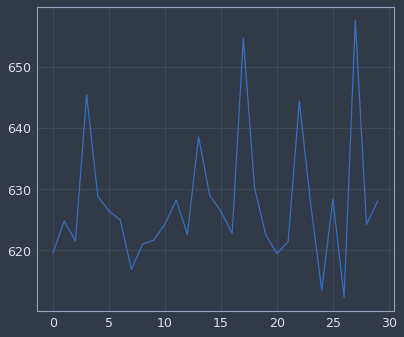

In [6]:
env_kwargs['n_envs'] = 512
episode_reward_sums += a3c_alg.train(n_episodes=30, **rl_alg_kwargs, **env_kwargs)
plt.plot(episode_reward_sums)
plt.show();

In [141]:
# 108 is good, but pretty much even against v_3 (1053 - 18 - 929)
# 156 is good, but even against v_3 (983 - 24 - 993)
# 162 is best against v0-2, not as better against pull_vegas, and even against v_3 (1954 - 58 - 1988)
# 164 is worth considering, with large margins against the field except v_3 who it's slightly behind
# 152 BEATS EVERYONE

# To submit later?
# 128 is mostly even against v3 like 108 (2011 - 64 - 1925)
# 157 beats everyone, but even against v_3



temp_model = a3c_alg.model_constructor()
temp_model.load_state_dict(a3c_alg.checkpoints[164])
temp_model.to(device=DEVICE)
temp_model.eval();

def model_wrapped(states):
    return temp_model.sample_action(states.unsqueeze(0)).squeeze(0)

In [143]:
#(a3c_alg.opp_a / (a3c_alg.opp_a + a3c_alg.opp_b)).argmax() - len(initial_opponent_pool)
est_opp_skill = a3c_alg.opp_a / (a3c_alg.opp_a + a3c_alg.opp_b)
ranking = np.argsort(-est_opp_skill)
idx = 0
print(f'Opponent {ranking[idx]}, ranked {idx+1}, has an estimated win % of {est_opp_skill[ranking[idx]]:.2f}.')
print(f'Checkpoint #{ranking[idx] - len(a3c_alg.initial_opponent_pool)}')
np.argsort(-est_opp_skill)

Opponent 113, ranked 1, has an estimated win % of 0.59.
Checkpoint #108


array([113, 161,  42,  32,  60,   4, 167,  82, 133, 142, 169, 157, 122,
       162,  41,  17,   6, 131, 163,  63,  55, 121,  51, 146, 120,  97,
       152,  19, 117, 158,  98, 109, 105,  50, 104, 164, 149, 153,  83,
       155, 128, 114, 150,  64,  86,   0,  84,  66,  53, 138,  27, 119,
        48,  88, 132,  89, 112, 148,  80,   3, 124,  43, 141,  31, 139,
       145, 134,  76,  87, 111,  85, 100, 154,   7,  21, 130,  34,  20,
        24,  79, 123, 116,  93,  94,  36, 147, 136, 118, 156,  99,  74,
       125, 160, 110,  25,  69, 135, 102,  52,  44,  45,  90, 140,  71,
        92, 115, 101,  23,  70,  65,  35,  14, 108,  40, 144,   9,  10,
        26,  68,  33,  95,  61, 166, 151,  47,  91, 159,  11,  56, 107,
       168,   8,  30,  58,  77,  39,  67, 143,  15, 106,  28,  38,  46,
        16,  22, 137,  59,  29,   5, 127,  62,  54, 129,   2,  96, 103,
        12,  81,  18,  73,  13,  37, 165,  78,  72,  75,  57,   1, 126,
        49])

## Benchmark the model against a previous RL agent, and various hand-crafted algorithms

In [142]:
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v3'), 'new_model', 'a3c_agent_v3', n_envs=4000, out_device=DEVICE)

100%|██████████| 1999/1999 [00:50<00:00, 39.85it/s]


new_model -vs- a3c_agent_v3
Mean scores: 640.83 - 641.77
Match score: 1930 - 55 - 2015


In [125]:
model.eval()
benchmark_env_kwargs = dict(
    n_envs=1000,
    out_device=DEVICE
)

## Previous best models
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v0'), 'new_model', 'a3c_agent_v0', **benchmark_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v1'), 'new_model', 'a3c_agent_v1', **benchmark_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v2'), 'new_model', 'a3c_agent_v2', **benchmark_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v3'), 'new_model', 'a3c_agent_v3', **benchmark_env_kwargs)

## Always 0 agent
#va.run_vectorized_vs(model_wrapped, va.AlwaysFirstAgent(), 'new_model', 'always_first', **benchmark_env_kwargs)

## Random agent
#va.run_vectorized_vs(model_wrapped, va.RandomAgent(), 'new_model', 'random_agent', **benchmark_env_kwargs)

## Basic thompson sampling
va.run_vectorized_vs(model_wrapped, va.BasicThompsonSampling(OBS_NORM), 'new_model', 'basic_thompson_sampling', **benchmark_env_kwargs)

## Pull vegas slot machines
va.run_vectorized_vs(model_wrapped, va.PullVegasSlotMachines(OBS_NORM), 'new_model', 'pull_vegas_slot_machines', **benchmark_env_kwargs)

100%|██████████| 1999/1999 [00:10<00:00, 186.52it/s]


new_model -vs- a3c_agent_v0
Mean scores: 651.22 - 627.79
Match score: 784 - 13 - 203


100%|██████████| 1999/1999 [00:12<00:00, 156.14it/s]


new_model -vs- a3c_agent_v1
Mean scores: 643.23 - 630.17
Match score: 668 - 15 - 317


100%|██████████| 1999/1999 [00:14<00:00, 139.66it/s]


new_model -vs- a3c_agent_v2
Mean scores: 641.47 - 633.20
Match score: 622 - 11 - 367


100%|██████████| 1999/1999 [00:14<00:00, 140.94it/s]


new_model -vs- a3c_agent_v3
Mean scores: 641.49 - 640.91
Match score: 487 - 15 - 498


100%|██████████| 1999/1999 [00:08<00:00, 247.26it/s]


new_model -vs- basic_thompson_sampling
Mean scores: 655.36 - 621.63
Match score: 879 - 1 - 120


100%|██████████| 1999/1999 [00:08<00:00, 242.01it/s]


new_model -vs- pull_vegas_slot_machines
Mean scores: 652.28 - 627.99
Match score: 771 - 5 - 224


## Benchmark the model against the checkpointed version

In [ ]:
model.eval()
benchmark_env_kwargs = dict(
    n_envs=1000,
    out_device=DEVICE
)

checkpointed_model = GraphNN_A3C(**graph_nn_kwargs)
checkpointed_model.to(torch.device('cuda'))
checkpointed_model.load_state_dict(model_sd_checkpoint)
checkpointed_model.eval()

def checkpointed_model_wrapped(states):
    return checkpointed_model.sample_action(states.unsqueeze(0)).squeeze(0)

va.run_vectorized_vs(model_wrapped, checkpointed_model_wrapped, 'new_model', 'checkpointed_model', **benchmark_env_kwargs)

In [ ]:
temp_sd_checkpoint = model.state_dict()

## Visualize model parameter distributions

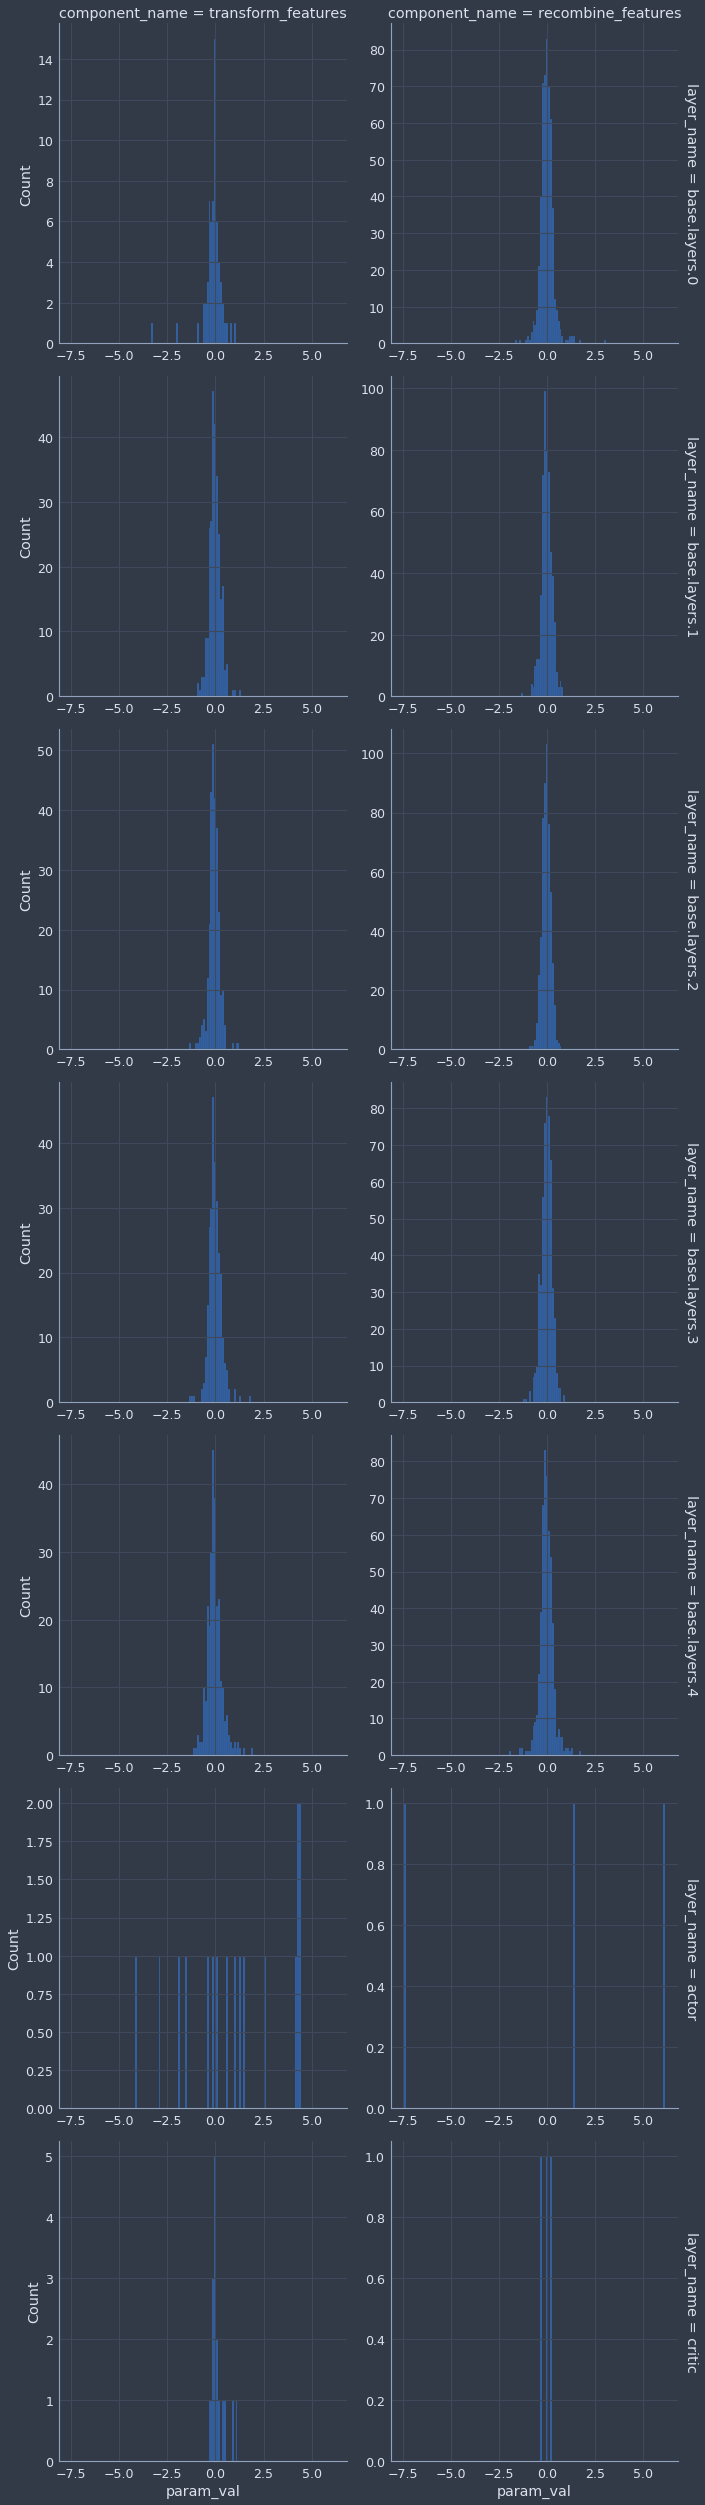

In [17]:
full_layer_name = []
layer_name = []
component_name = []
weight_or_bias = []
param_val = []
for key, val in model.state_dict().items():
    if 'message_passing_mat' in key:
        pass
    else:
        for v in val.cpu().numpy().ravel():
            param_val.append(v)
            full_layer_name.append(key)
            key_split = key.split('.')
            if len(key_split) == 3:
                ln, pn, wob = key_split
            elif len(key_split) >= 4:
                ln = '.'.join(key_split[0:-2])
                pn, wob = key_split[-2:]
            else:
                raise RuntimeError(f'Unrecognized layer key: {key}')
            layer_name.append(ln)
            component_name.append(pn)
            weight_or_bias.append(wob)
params_df = pd.DataFrame(dict(
    full_layer_name = full_layer_name,
    layer_name = layer_name,
    component_name = component_name,
    weight_or_bias = weight_or_bias,
    param_val = param_val
))

sns.displot(
    params_df, x='param_val', col='component_name', row='layer_name',
    binwidth=0.1,
    #height=3,
    facet_kws=dict(margin_titles=True, sharex=False, sharey=False)
);

In [ ]:
full_layer_name = []
layer_name = []
component_name = []
weight_or_bias = []
param_val = []
for key, val in GraphNN_A3C(**graph_nn_kwargs).state_dict().items():
    if 'message_passing_mat' in key:
        pass
    else:
        for v in val.cpu().numpy().ravel():
            param_val.append(v)
            full_layer_name.append(key)
            key_split = key.split('.')
            if len(key_split) == 3:
                ln, pn, wob = key_split
            elif len(key_split) >= 4:
                ln = '.'.join(key_split[0:-2])
                pn, wob = key_split[-2:]
            else:
                raise RuntimeError(f'Unrecognized layer key: {key}')
            layer_name.append(ln)
            component_name.append(pn)
            weight_or_bias.append(wob)
params_df = pd.DataFrame(dict(
    full_layer_name = full_layer_name,
    layer_name = layer_name,
    component_name = component_name,
    weight_or_bias = weight_or_bias,
    param_val = param_val
))

sns.displot(
    params_df, x='param_val', col='component_name', row='layer_name',
    binwidth=0.1,
    #height=3,
    facet_kws=dict(margin_titles=True, sharex=False, sharey=False)
);

## Save the model state_dict as a serialized string

In [27]:
model.to('cpu')
state_dict_bytes = pickle.dumps({
    'model_state_dict': model.state_dict(),
    #'optimizer_state_dict': optimizer.state_dict()
})
serialized_string = base64.b64encode(state_dict_bytes)
with open('rl_agents/ss_temp.txt', 'w') as f:
    f.write(str(serialized_string))
model.to(device=DEVICE);

## Testing and debugging

In [19]:
s.shape

torch.Size([1, 2, 100, 3])

In [18]:
from scipy.stats import spearmanr, pearsonr

test_env = KaggleMABEnvTorchVectorized(n_players=2, decay_rate=0.97)
with torch.no_grad():
    test_env.reset()
    # Take n good actions
    for i in range(500):
        actions = test_env.thresholds.argmax(axis=-1)[:, None]
        s, _, _, _ = test_env.step(actions.repeat(1, test_env.n_players))
    logits, values = model(s[0,0].to(device=DEVICE)[None, None, :])
    logits = logits.cpu().numpy().squeeze()
    values = values.cpu().numpy().squeeze()
print()
print(logits)
print(values)
print(s[:,0].squeeze().t())
print(spearmanr(logits, test_env.thresholds.squeeze().cpu().numpy())[0],
      pearsonr(logits, test_env.thresholds.squeeze().cpu().numpy())[0])


[ -50.70728   343.18048  -360.98813  -184.58109   343.18048   343.18048
 -179.55315  -371.94223   343.18048  -101.76725  -289.71634   343.18048
  343.18033  -101.76725  -101.7673    343.1806    343.18048   -55.70023
 -423.23956   343.18048   343.18048  -144.07784  -483.9645   -132.49835
  343.18048  -284.71515  -214.44508   -36.317387  343.18033   343.1806
 -144.07787  -181.13568  -172.01115   330.54306  -392.00793   -42.726707
 -100.718575  343.18048  -232.7463   -184.58109  -182.04886   343.18048
 -209.41711  -139.44606  -169.4972    343.1806    343.18033  -309.7208
  343.18048   330.54306  -137.13019  -130.38986   343.18048   343.18048
  343.18048  -206.90314   343.18048   132.18704  -179.55313  -289.71637
 -141.76196   343.1806    343.18033  -222.74408   343.18048   343.18048
 -360.98813   343.18048   343.18048   343.18048  -174.52518  -166.98323
  343.18048   -50.707306 -164.46925   -50.707294 -130.38986  -416.65625
 -164.46925   343.1806   -209.41711  -100.9217    343.18048  -18

In [ ]:
child_layer_idx = -1
child_layer = list(model.children())[child_layer_idx]
print(child_layer.transform_features.weight.data, child_layer.transform_features.bias.data)
print(child_layer.recombine_features.weight.data, child_layer.recombine_features.bias.data)
print(model)
print(child_layer)

In [ ]:
test_env = KaggleMABEnvTorchVectorized(n_envs=3, n_players=2, decay_rate=0.97, env_device=torch.device('cpu'), out_device=DEVICE)
test_env.reset()
actions = torch.arange(6).view(3,2)
test_env.step(actions)
test_env.step(actions)
actions = torch.arange(1,7).view(3,2)
test_env.step(actions)
test_env.step(actions)
test_env.step(actions)

test = test_env.player_n_pulls.unsqueeze(3).expand(-1,-1,-1,2).transpose(1,3)
test = torch.cat([
    test[:,0,:,:].unsqueeze(1),
    test[:,0,:,[1,0]].unsqueeze(1)
], dim=1)
test[0,0]
test_env.player_rewards_sums

In [ ]:
# Simulated env rollouts with random policy
test_env = KaggleMABEnvTorchVectorized(n_envs=1000, n_players=2, decay_rate=0.97, env_device=torch.device('cuda'), out_device=torch.device('cuda'))

for i in tqdm.trange(test_env.n_steps):
    actions = torch.randint(test_env.n_bandits, size=(test_env.n_envs, test_env.n_players))
    test_env.step(actions)
print(f'Mean of player rewards: {test_env.player_rewards_sums.sum(axis=-1).mean():.2f}, Standard deviation of player rewards: {test_env.player_rewards_sums.sum(axis=-1).std():.2f}')

In [ ]:
# Simulated env rollouts with omniscient optimal policy
test_env = KaggleMABEnvTorchVectorized(n_envs=1000, n_players=2, decay_rate=0.97, env_device=torch.device('cuda'), out_device=torch.device('cpu'))

for i in tqdm.trange(test_env.n_steps):
    actions = test_env.thresholds.argmax(axis=-1)[:, None]
    test_env.step(actions.repeat(1, test_env.n_players))
print(f'Mean of player rewards: {test_env.player_rewards_sums.sum(axis=-1).mean():.2f}, Standard deviation of player rewards: {test_env.player_rewards_sums.sum(axis=-1).std():.2f}')

In [ ]:
n_nodes = 10
activation_func = nn.ReLU()
layer_size = 64
layers = (
    [FullyConnectedGNNLayer(n_nodes, 1, layer_size, activation_func=activation_func)] +
    [FullyConnectedGNNLayer(n_nodes, layer_size, layer_size, activation_func=activation_func)] * 0 +
    [FullyConnectedGNNLayer(n_nodes, layer_size, 1, activation_func=activation_func)]
)
model = nn.Sequential(
    *layers
)
#model = FullyConnectedGNNLayer(n_nodes, 1, 1, activation_func=nn.Identity())
model.train()
model.to('cuda')
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0002)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for i in tqdm.trange(10):
    train_batch_in = torch.rand((250, n_nodes, 1), dtype=torch.float).to('cuda')
    k = 2
    labels = torch.topk(train_batch_in, k=k, dim=1).indices[:,k-1]
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
print(f'Loss: {loss:.2f}, Accuracy: {accuracy:.3f}')

test_batch_in = torch.rand((1, n_nodes, 1), dtype=torch.float).to('cuda')
print(test_batch_in)
print(F.softmax(model(test_batch_in), dim=1))
print(torch.topk(test_batch_in, k=k, dim=1).indices[:,k-1])
print(F.softmax(model(test_batch_in), dim=1).argmax(dim=1))

In [ ]:
for i in tqdm.trange(1000):
    train_batch_in = torch.rand((250, n_nodes, 1), dtype=torch.float).to('cuda')
    k = 2
    labels = torch.topk(train_batch_in, k=k, dim=1).indices[:,k-1]
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
print(f'Loss: {loss:.2f}, Accuracy: {accuracy:.3f}')

In [ ]:
model = FullyConnectedGNNLayer(5, 1, 1, activation_func=nn.Identity())
model.train()
model.to('cuda')
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.)

for i in tqdm.trange(10000):
    train_batch_in = torch.rand((1024, 5, 1), dtype=torch.float).to('cuda')
    train_batch_out = train_batch_in + train_batch_in.sum(dim=1, keepdims=True)
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, train_batch_out)
    loss.backward()
    optimizer.step()
loss

In [ ]:
train_batch_in = torch.rand((2, 5, 1), dtype=torch.float).to('cuda')
print(train_batch_in)
print(train_batch_in + train_batch_in.sum(dim=1, keepdims=True))
print(model(train_batch_in))

## Deprecated

In [ ]:
# Loosely based on: https://github.com/MorvanZhou/pytorch-A3C
def a3c_vectorized_env(env, model, optimizer, n_episodes, batch_size,
                       gamma=0.9):
    model.to(device=DEVICE)
    model.train()
    episode_reward_sums = []
    
    for episode in tqdm.trange(n_episodes):
        buffer_s, buffer_a, buffer_r = [], [], []
        s, r, _, _ = env.reset()
        episode_reward_sums.append(r)
        step_count = 1
        while not env.done:
            # Batch size of 1 for inference
            a = model.sample_action(s.to(device=DEVICE).unsqueeze(0)).squeeze(0)
            next_s, r, done, _ = env.step(a)
            
            #print(s.shape, a.shape, r.shape)
            buffer_s.append(s)
            buffer_a.append(a)
            buffer_r.append(r)
            
            if step_count % batch_size == 0 or done:
                if done:
                    v_next_s = torch.zeros_like(buffer_r[-1])
                else:
                    _, v_next_s = model(next_s.to(device=DEVICE).unsqueeze(0))
                    v_next_s = v_next_s.detach().squeeze(0)
                v_next_s.to(device=DEVICE)
                
                buffer_v_target = []
                for r in buffer_r[::-1]:
                    v_next_s = r + gamma * v_next_s
                    buffer_v_target.append(v_next_s)
                buffer_v_target.reverse()
                
                loss = model.loss_func(
                    torch.stack(buffer_s).to(device=DEVICE),
                    torch.stack(buffer_a).to(device=DEVICE),
                    torch.stack(buffer_v_target).to(device=DEVICE)
                )
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                buffer_s, buffer_a, buffer_r = [], [], []
            s = next_s
            episode_reward_sums[-1] += r
            step_count += 1
        episode_reward_sums[-1] = episode_reward_sums[-1].mean()
    return episode_reward_sums

In [ ]:
class Kaggle_MAB_Env_Numpy_Vectorized():
    def __init__(self,
                 # Kaggle MAB env params
                 n_bandits=100, n_steps=1999, decay_rate=0.97, sample_resolution=100,
                 # Custom params
                 n_envs=1, n_players=2, reward_type=EVERY_STEP, remove_extra_dims=False):
        # Assert parameter conditions
        assert 0 <= decay_rate <= 1.
        assert reward_type in (END_OF_GAME, EVERY_STEP)
        if reward_type == END_OF_GAME:
            assert n_players >= 2
        else:
            assert n_players >= 1
        self.n_bandits = n_bandits
        self.n_steps = n_steps
        self.decay_rate = decay_rate
        self.sample_resolution = sample_resolution
        
        self.n_envs = n_envs
        self.n_players = n_players
        self.reward_type = reward_type
        self.remove_extra_dims = remove_extra_dims
        
        self.timestep = None
        self.orig_thresholds = None
        self.player_n_pulls = None
        self.player_rewards_sums = None
        self.reset()
    
    @property
    def thresholds(self):
        return self.orig_thresholds * (self.decay_rate ** self.player_n_pulls[:,0,:])
    
    def reset(self):
        self.timestep = 0
        self.orig_thresholds = np.random.randint(self.sample_resolution + 1, size=(self.n_envs, self.n_bandits)).astype(np.float32)
        self.player_n_pulls = np.zeros((self.n_envs, self.n_players, self.n_bandits))
        self.player_rewards_sums = np.zeros_like(self.player_n_pulls)
        
        rewards = np.zeros((self.n_envs, self.n_players))
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
        
    def step(self, actions):
        if self.remove_extra_dims:
            if type(actions) == int:
                actions = np.array([[actions]])
            else:
                actions = actions.reshape((self.n_envs, self.n_players))
        assert actions.shape == (self.n_envs, self.n_players), f'actions.shape was: {actions.shape}'
        assert not self.done
        self.timestep += 1
        
        # Compute agent rewards
        selected_thresholds = np.take_along_axis(self.thresholds, actions, axis=1)
        pull_rewards = np.random.randint(self.sample_resolution, size=selected_thresholds.shape) < selected_thresholds
        #pull_rewards = selected_thresholds / float(self.sample_resolution)
        
        # Update player_n_pulls and player_rewards_sums
        for env_idx, env_actions in enumerate(actions):
            for player_idx, pull_idx in enumerate(env_actions):
                self.player_n_pulls[env_idx, :, pull_idx] += 1
                self.player_rewards_sums[env_idx, player_idx, pull_idx] += pull_rewards[env_idx, player_idx]
        
        # Return (obs, reward, done) tuple
        if self.reward_type == END_OF_GAME:
            rewards = np.zeros_like(actions)
            if self.timestep == self.n_steps:
                rewards_sums = self.player_rewards_sums.sum(axis=2)
                winners = rewards_sums.argmax(axis=1)
                rewards[winners] = 1
        elif self.reward_type == EVERY_STEP:
            rewards = pull_rewards
        
        # State, reward, done, info_dict
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
    
    def get_obs(self):
        # TODO: Clearly do not return thresholds or orig_thresholds
        return np.stack([
            #np.broadcast_to(self.orig_thresholds[:, None, :] / self.sample_resolution, self.player_n_pulls.shape),
            self.player_n_pulls,
            self.player_rewards_sums
        ], axis=-1).astype(np.float32)
    
    @property
    def done(self):
        return self.timestep >= self.n_steps

In [ ]:
class FeedForwardNN_A3C(nn.Module):
    def __init__(self, in_features, n_bandits, activation_func=nn.ReLU()):
        super().__init__()
        self.in_features = in_features
        self.activation_func = activation_func
        layer_size = 128
        self.base = nn.Sequential(
            nn.Linear(self.in_features, layer_size),
            activation_func,
            nn.Linear(layer_size, layer_size),
            activation_func,
        )
        self.actor = nn.Linear(layer_size, n_bandits)
        self.critic = nn.Linear(layer_size, 1)
        
    def forward(self, states):
        in_shape = states.shape
        base_out = self.base(states.view(-1, self.in_features))
        return self.activation_func(self.actor(base_out)).view(in_shape[:-1]), self.critic(base_out).view(in_shape[:-2])
    
    def sample_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            probs = F.softmax(logits, dim=-1)
            batch_size, n_envs, n_players, n_bandits = probs.shape
            m = distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
            return m.sample().view(batch_size, n_envs, n_players)
    
    def choose_best_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            return logits.argmax(dim=-1)
        
    def loss_func(self, states, actions, v_t):
        #print(f'states.shape: {states.shape}, actions.shape: {actions.shape}, v_t.shape: {v_t.shape}')
        logits, values = self.forward(states)
        
        #print(f'logits.shape: {logits.shape}, values.shape: {values.shape}')
        td = v_t - values
        critic_loss = td.pow(2).view(-1)
        
        probs = F.softmax(logits, dim=-1)
        batch_size, n_envs, n_players, n_bandits = probs.shape
        m = distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
        #print(f'm.log_prob(actions.view(batch_size * n_envs * n_players)).shape: {m.log_prob(actions.view(batch_size * n_envs * n_players)).shape}, td.shape: {td.shape}')
        actor_loss = -(m.log_prob(actions.view(-1)) * td.detach().view(-1))
        total_loss = (critic_loss + actor_loss).mean()
        return total_loss